# NFL Punt Rule Suggestion - Enforce Maximum Number of Jammers
### *Sameer Vinayak*
[Github](https://github.com/sameervinayak31),
[LinkedIn](https://www.linkedin.com/in/sameervinayak/)



In this notebook, I explored the NFL's question: Is there a rule change that can be implemented on punt plays that can make the plays safer, and in particular reduce the incidence of concussions? 

Outlined step by step below, my research led me to analyzing the formations deployed on these plays, in particular by the return team. In the end, my conclusion and proposed rule change are as follows:

Punts, like kickoffs, are innately dangerous plays, consisting of players running towards each other at high speeds. The NFL has acknowledged this as fact on kickoffs, and has made [appropriate rule changes](http://www.espn.com/blog/nflnation/post/_/id/287320/the-nfl-rule-tweaks-saving-kickoff-from-extinction) that keep the integrity of the play intact while reducing the chance of injury. Now, they are looking to do the same for punts. 

Only 8% of the plays in which concussions occured were fair catch plays, which makes sense - fewer injuries occur when a play is shortened. The research below suggests that fair catches are far more likely to occur when return teams deploy 8-man "boxes" rather than 6-man boxes. This is a result of the players not in the box - jammers. When 6-man boxes are utilized, two jammers are assigned to block each punt gunner, resulting in an increased likelihood of a well-blocked field in which the returner can operate. 8-man boxes, on the other hand, generally allow the gunners to close is on the returner more easily, leading to fair catches.

Mandating teams to use 8-man boxes should not drastically impact the upside of punt plays - it will instead primarily serve as a way to nudge returners to call for a fair catch. While this will reduce the number of meaningful returns, it is a fair trade-off, and one the NFL has exercised in the past on other plays, with the massive benefit of player safety. From a public relations standpoint, the rule change is subtle enough that  I suspect that the implications of the change will not be immediately clear to most fans (in contrast, for example, to recent quarterback safety rules which require penalties to be called, impacting the game in a more obvious way and thus invoking a response from fans), reducing the potential backlash faced from fans who are particularly fond of refraining from deviating from the game's rich history.

### **Rule Proposal**: On any punt play, the return team must have no more than an equal amount of players as the punting team lined up on or outside of the yardage numbers on the field. See diagram [here](https://imgur.com/HCWi0cs). In line with the current rules, the following note applies:
"*The restriction does not apply if a team does not present a standard punt formation (an equal number of
        players on either side of the snapper in a tight formation, and one player split out wide to either side), or if, after the
        offensive team has assumed a set position, there is a shift, or a player goes in motion*" [(Rule 9, Section 1)](https://operations.nfl.com/media/3277/2018-nfl-rulebook_final-version.pdf).

## Research & Code Walkthrough

After importing and some simple joining of the different datasets, I imported the NextGenStats files. The NGS dataset is relatively large, 
and manually defining the expected data types before importing helps to limit the amount of space used and
optimize for speed (adapted from a kernel posted by [Kevin Mader](https://www.kaggle.com/kmader/convert-to-feather-for-use-in-other-kernels)). The play-level contents of the files have been combined and stored in three CSV files for quicker i/o. 

In [113]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import gc
import math
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import random
import tqdm
import scipy
from statsmodels.stats.proportion import proportions_ztest
from timeit import timeit
from scipy.stats.stats import pearsonr 
import re


In [114]:
concussion_how = pd.read_csv('../input/NFL-Punt-Analytics-Competition/video_review.csv')
player_punt_role = pd.read_csv('../input/NFL-Punt-Analytics-Competition/play_player_role_data.csv')
player_role = pd.read_csv('../input/NFL-Punt-Analytics-Competition/player_punt_data.csv')
player_role.drop_duplicates(['GSISID'],keep='first',inplace=True)
video = pd.read_csv('../input/NFL-Punt-Analytics-Competition/video_footage-injury.csv')
video_non = pd.read_csv('../input/NFL-Punt-Analytics-Competition/video_footage-control.csv')
play_info = pd.read_csv('../input/NFL-Punt-Analytics-Competition/play_information.csv')

tqdm.tqdm.pandas()
pd.set_option('display.max_columns', 500)

concussion_plays_temp = pd.merge(concussion_how,player_punt_role[['PlayID','GSISID','GameKey','Role']],how='left',on=['PlayID','GSISID','GameKey'])
concussion_plays_temp2 = pd.merge(concussion_plays_temp, player_role[['GSISID','Position']],how='left',on='GSISID')
concussion_plays = concussion_plays_temp2.rename(columns={'Role':'Player Role','Position':'Player Position'})

player_punt_role['GSISID'] = player_punt_role['GSISID'].astype(str)
concussion_plays =  pd.merge(concussion_plays,player_punt_role[['PlayID','GSISID','GameKey','Role']],how='left',left_on = ['PlayID','Primary_Partner_GSISID','GameKey'],right_on=['PlayID','GSISID','GameKey'])
concussion_plays = concussion_plays.rename(columns={'Role':'Partner Role'})
non_subset = pd.read_csv('../input/nflpuntfilesfinal/non_subset_factors (3).csv')
concussion_plays = pd.read_csv('../input/nflpuntfilesfinal/concussion_plays_factors (3).csv')
non_subset['Men In Box'] = non_subset['Men In Box'].mask(non_subset['Men In Box'] > 11, np.nan)
non_concussion_all = pd.read_csv('../input/non-con-all/non_concussion_plays_all (1).csv')
non_concussion_all['Men In Box'] = non_concussion_all['Men In Box'].mask(non_concussion_all['Men In Box'] > 11, np.nan)
non_concussion_all['Men In Box'] = non_concussion_all['Men In Box'].mask(non_concussion_all['Men In Box'] < 4, np.nan)
non_concussion_all['key'] = non_concussion_all['GSISID'].astype(str) + '-'+ non_concussion_all['GameKey'].astype(str) + '-'+ non_concussion_all['PlayID'].astype(str)
non_concussion_all = non_concussion_all[~non_concussion_all['key'].isin(concussion_plays['key'])]


In [115]:
def import_ngs():
    dtypes = {'Season_Year': 'int16',
             'GameKey': 'int64',
             'PlayID': 'int16',
             'GSISID': 'float32',
             'Time': 'str',
             'x': 'float32',
             'y': 'float32',
             'dis': 'float32',
             'o': 'float32',
             'dir': 'float32',
             'Event': 'str'}
    
    col_names = list(dtypes.keys())
    
    # import all ngs files
    
    ngs_files = ['NGS-2016-pre.csv',
                 'NGS-2016-reg-wk1-6.csv',
                 'NGS-2016-reg-wk7-12.csv',
                 'NGS-2016-reg-wk13-17.csv',
                 'NGS-2016-post.csv',
                 'NGS-2017-pre.csv',
                 'NGS-2017-reg-wk1-6.csv',
                 'NGS-2017-reg-wk7-12.csv',
                 'NGS-2017-reg-wk13-17.csv',
                 'NGS-2017-post.csv']
    
    df_list = []
    
    for i in ngs_files:
        df = pd.read_csv('../input/NFL-Punt-Analytics-Competition/'+i, usecols=col_names,dtype=dtypes)
        df_list.append(df)
        print(i)
        
    ngs = pd.concat(df_list)
    
    # Delete the dataframe list to release memory
    del df_list
    gc.collect()
    
    # Convert Time to datetime
    ngs['Time'] = pd.to_datetime(ngs['Time'], format='%Y-%m-%d %H:%M:%S')
    
    # See what we have loaded
    
    ngs['Season_Year'] = ngs['Season_Year'].astype('category').cat.codes
    ngs = ngs[~ngs['GSISID'].isna()]
    ngs['GSISID'] = ngs['GSISID'].astype('int32')
    ngs.reset_index(drop=True,inplace=True)
    
    #ngs.to_feather('ngs_fet.feather')
    return ngs

#ngs = import_ngs()
#print('Done.')

After much poking around with players' velocities on an individual and play level, I decided to 
broaded the scope to focus instead on what causes a player to reach faster speeds on a play - their position.

Similar to how on defense teams enter nickel or dime packages that feature faster players to serve specific purposes,
the return team on punt plays varies its personnel and alignment based on its objectives for the play. Note that a key difference is
that on defense, the personnel and formation are more likely to be dictated to an extent by the offense's personnel and formation. 
Meanwhile, on punt plays, it appears that the return team often doesn't have to react to the punting team's formation - this remains
largely static. I've provided some confirmation for this below in the notebook.

In order to learn more about the formations that return teams deployed, I used the NGS dataset to estimate the number of 
players lined up 'in the box' - that is, directly opposing the offensive line. I defined this as being within 10 yards
of the long snapper at the time of the snap. I also pulled in the position list for both teams to get a sense for which punt roles were being featured and how
that impacted the plays and their safety.

In [116]:
def men_in_box(row):
    """
    This function calculates the number of players on the return team considered lined up 'in the box' 
    at the time of the snap. I used being within 10 yards of the long snapper as a proxy for being 
    considered lined up in the box. 
    
    There was one anomalous case that resulted in 20 players being considered 'in the box', so I
    filtered that out manually. Other than that, the results fit within reason and were confirmed visually 
    where possible.   
    """
    gsisid = row['GSISID']
    play = row['PlayID']
    game = row['GameKey']
    
    return_team_pos = [
 'PDL1','PDL2','PDL3','PDL4','PDL5','PDL6',
 'PDM','PDR1','PDR2','PDR3','PDR4','PDR5',
 'PDR6', 'PLL','PLL1','PLL2','PLL3','PLM',
 'PLM1','PLR','PLR1','PLR2','PLR3','PR',
 'VL', 'VLi','VLo','VR','VRi','VRo', 'PFB','PLS']
    
    #get all players on return team
    play_tracking = ngs[(ngs['GameKey'] == game) & (ngs['PlayID'] == play)]
    play_tracking['GSISID'] = play_tracking['GSISID'].astype(str)
    play_tracking = pd.merge(play_tracking,player_punt_role[['PlayID','GSISID','GameKey','Role']],how='left',on=['PlayID','GSISID','GameKey'])
    return_team_tracking = play_tracking[play_tracking['Role'].isin(return_team_pos)]
    return_team_starting_pos = return_team_tracking[return_team_tracking['Event'] == 'ball_snap']
    if len(return_team_starting_pos[return_team_starting_pos['Role'] == 'PLS']) == 0:
        return np.nan
    
    #locate the long snapper & determine in/out status
    x_ls = return_team_starting_pos[return_team_starting_pos['Role'] == 'PLS']['x'].values[0]
    y_ls = return_team_starting_pos[return_team_starting_pos['Role'] == 'PLS']['y'].values[0]
    men_in_box = 0
    for gsid in return_team_starting_pos[return_team_starting_pos['Role'] != 'PLS']['GSISID']:
        player = return_team_starting_pos[return_team_starting_pos['GSISID'] == gsid]
        x_in = (player['x'].values[0] > x_ls - 10.0) & (player['x'].values[0] < x_ls + 10.0)
        y_in = (player['y'].values[0] > y_ls - 10.0) & (player['y'].values[0] < y_ls + 10.0) 
        if x_in and y_in:
            men_in_box += 1
            
    #discard any errors
    if (men_in_box > 11) or (men_in_box < 4):
        return np.nan
    return men_in_box


def get_kick_list(key):
    """
    Takes in the key (created by combining the GameKey and PlayID separated by a hyphen)
    and outputs the list of roles used by the kicking team on that play.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    return_team_pos = [
 'PDL1','PDL2','PDL3','PDL4','PDL5','PDL6',
 'PDM','PDR1','PDR2','PDR3','PDR4','PDR5',
 'PDR6', 'PLL','PLL1','PLL2','PLL3','PLM',
 'PLM1','PLR','PLR1','PLR2','PLR3','PR',
 'VL', 'VLi','VLo','VR','VRi','VRo', 'PFB']
    
    all_players = ngs[(ngs['GameKey'] == int(gameID)) & (ngs['PlayID'] == int(playID))]
    all_players['GSISID'] = all_players['GSISID'].astype(str)
    all_players = pd.merge(all_players,player_punt_role[['PlayID','GSISID','GameKey','Role']],how='left',on=['PlayID','GSISID','GameKey'])
    all_roles = set(all_players['Role'])
    kick_roles = []
    for role in all_roles:
        if role not in return_team_pos:
            kick_roles.append(role)
    kick_roles = [x for x in kick_roles if type(x) == str]
    return kick_roles


def get_ret_list(key):
    """
    Takes in the play key (created by combining the GameKey and PlayID separated by a hyphen)
    and outputs the list of roles used by the return team on that play.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    return_team_pos = [
 'PDL1','PDL2','PDL3','PDL4','PDL5','PDL6',
 'PDM','PDR1','PDR2','PDR3','PDR4','PDR5',
 'PDR6', 'PLL','PLL1','PLL2','PLL3','PLM',
 'PLM1','PLR','PLR1','PLR2','PLR3','PR',
 'VL', 'VLi','VLo','VR','VRi','VRo', 'PFB']
    
    all_players = ngs[(ngs['GameKey'] == int(gameID)) & (ngs['PlayID'] == int(playID))]
    all_players['GSISID'] = all_players['GSISID'].astype(str)
    all_players = pd.merge(all_players,player_punt_role[['PlayID','GSISID','GameKey','Role']],how='left',on=['PlayID','GSISID','GameKey'])
    all_roles = set(all_players['Role'])
    ret_roles = []
    for role in all_roles:
        if role in return_team_pos:
            ret_roles.append(role)
    ret_roles = [x for x in ret_roles if type(x) == str]
    return ret_roles

The chart below show that there are three box sizes (6, 7, and 8) that are predominantly used by return teams. While for all punt plays in which concussions didn't occur the 8-man box was the most common, the same wasn't true for plays that led to concussions. The second chart shows that that distribution leans more towards 6-man boxes.

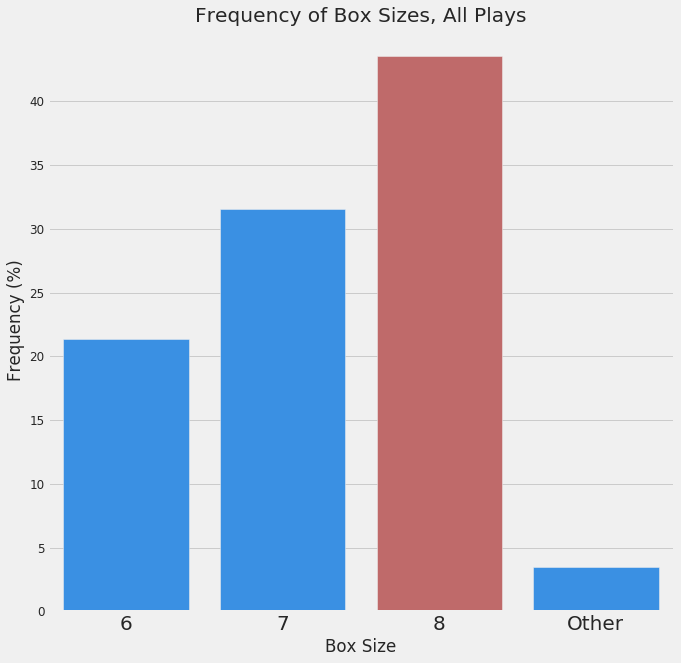

In [117]:
boxes = ['6','7','8','Other']
six = round(100*len(non_concussion_all[non_concussion_all['Men In Box']==6])/len(non_concussion_all['Men In Box'].dropna()),2)
seven = round(100*len(non_concussion_all[non_concussion_all['Men In Box']==7])/len(non_concussion_all['Men In Box'].dropna()),2)
eight = round(100*len(non_concussion_all[non_concussion_all['Men In Box']==8])/len(non_concussion_all['Men In Box'].dropna()),2)
other = 100 - six - seven - eight
freq = [six,seven,eight,other]
graph_df = pd.DataFrame({'Box Size':boxes,'Frequency':freq})

sns.set(style="whitegrid")
plt.style.use('fivethirtyeight');
clrs = ['dodgerblue','dodgerblue','indianred','dodgerblue']
f, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='Box Size',y='Frequency',data=graph_df,palette = clrs)
plt.xticks(size=20);
plt.yticks(np.arange(0,45,5),size=12)
plt.ylabel('Frequency (%)');
plt.title('Frequency of Box Sizes, All Plays');

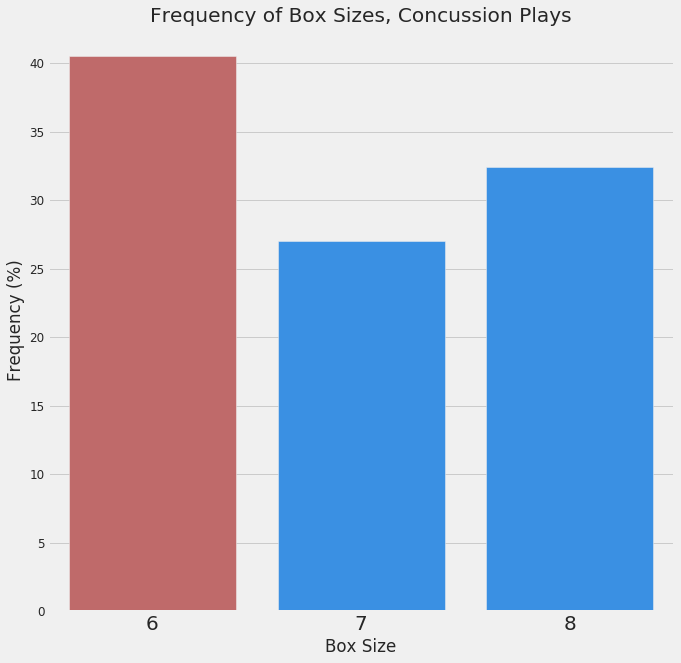

In [118]:

boxes = ['6','7','8']
six = round(100*len(concussion_plays[concussion_plays['Men In Box']==6])/len(concussion_plays['Men In Box'].dropna()),2)
seven = round(100*len(concussion_plays[concussion_plays['Men In Box']==7])/len(concussion_plays['Men In Box'].dropna()),2)
eight = round(100*len(concussion_plays[concussion_plays['Men In Box']==8])/len(concussion_plays['Men In Box'].dropna()),2)
freq = [six,seven,eight]
graph_df = pd.DataFrame({'Box Size':boxes,'Frequency':freq})

sns.set(style="whitegrid")
plt.style.use('fivethirtyeight');


f, ax = plt.subplots(figsize=(10, 10))
clrs = ['indianred','dodgerblue','dodgerblue']
sns.barplot(x='Box Size',y='Frequency',data=graph_df,palette = clrs)
plt.xticks(size=20);
plt.yticks(np.arange(0,45,5),size=12)
plt.ylabel('Frequency (%)');
plt.title('Frequency of Box Sizes, Concussion Plays');

The highly disparate proportions here (40.54% of plays using 6-man boxes for plays during which a concussion occured versus 21.39% for all others) is interesting. Before looking into how the personnel used for these plays varied, I confirmed using a Two Proportions Z Test that the percentages are significantly different given the sample sizes.

In [119]:
def test_significance(concussion_plays, non_concussion_plays):
    count = concussion_plays['Men In Box'].value_counts()[6]
    nobs = len(concussion_plays)
    value = (non_concussion_plays['Men In Box'].value_counts()/len(non_concussion_plays))[6]
    stat, pval = proportions_ztest(count, nobs, value)
    if pval < .05:
        result = """
        Given that the population proportion of instances in which there were six men in the \n\
        box on punts was {pop}, there is only a {pval} probability that the {pct} proportion \n\
        seen in the plays in which concussions occured was drawn from the population \n\
        distribution. Thus, at a 95% confidence level, we reject the null that the sample \n\
        and population means are equal.
        """.format(pop= round(value,6), pval = round(pval,6), pct = round(count/nobs,6))
    else:
        result =    """
        Given that the population proportion of instances in which there were six men in \n\ 
        the box on punts was {pop},there is a {pval} probability that the {pct} proportion \n\
        seen in the plays in which concussions occured was drawn from the population distribution.\n\ 
        Thus, we cannot reject the null that the sample and population means are equal.
        """.format(pop= round(value,6), pval = round(pval,6), pct = round(count/nobs,6))
    print(result)
    return pval

pval = test_significance(concussion_plays,non_concussion_all)


        Given that the population proportion of instances in which there were six men in the 
        box on punts was 0.207833, there is only a 0.014374 probability that the 0.405405 proportion 
        seen in the plays in which concussions occured was drawn from the population 
        distribution. Thus, at a 95% confidence level, we reject the null that the sample 
        and population means are equal.
        


This finding suggests that there may be some signal in the formations used by the return team. As mentioned earlier, the variation in formation and personnel is mainly a return-team-specific feature. Instead of plotting the specific formation on each play and trying to learn the different positions using clustering or other methods that may have been overkill, I used the position labels that were already given. This is an oversimplification, as not all players in the box necessarily run towards the punter when the ball is snapped. However, it serves as a useful model to represent the general formation and play call by the return team.

Below, we can see that the number of punt team gunners stays the same regardless of box size, but the number of jammers/corners doubles when moving from a 6-man box to an 8-man box. **This is the key feature of box sizes - whether or not the punting team's gunners are being double-teamed**. 

Moving forward, the comparisons being made will be between 6- and 8-man boxes. 7-man boxes, as one might expect, are simply a compromise between 6 and 8 in all aspects that were analyzed - for example, the average number of jammers for 7 man box plays was 2.9 (one gunner was double teamed instead of two), roughly halfway between the averages for 6- and 8-man boxes. All pro-8-man box arguments made in this proposal can be made more mild by substituting in 7-man boxes instead. 

In [120]:
six_gun = non_subset.groupby('Men In Box').mean()['count_gunners'][6]
eight_gun = non_subset.groupby('Men In Box').mean()['count_gunners'][8]

six_jam = non_subset.groupby('Men In Box').mean()['count_corners'][6]
eight_jam = non_subset.groupby('Men In Box').mean()['count_corners'][8]

print("Number of gunners on 6 man box plays: ", round(six_gun,1))
print("Number of gunners on 8 man box plays: ", round(eight_gun,1))
print(" ")
print("Number of jammers on 6 man box plays: ", round(six_jam,1))
print("Number of jammers on 8 man box plays: ", round(eight_jam,1))

Number of gunners on 6 man box plays:  2.0
Number of gunners on 8 man box plays:  2.0
 
Number of jammers on 6 man box plays:  3.9
Number of jammers on 8 man box plays:  2.0


Teams often utilize 6-man boxes (double-teaming both gunners) in order to allow their return man more room to operate. 8-man boxes, on the other hand, theoretically pressure the punter into making a rushed punt (or result in a blocked punt), but allow the gunners to close in on the punter with more ease. In order to move forward with the proposed rule change of mandating that gunners are only single teamed at most, it's important to analyze the different results that come of different box sizes to see the impact that the rule change may cause.

The data (shown in the output below) suggests a few things about how the box size impacts punt plays:
* Regardless of the box size, return yardage on plays in which the ball was fielded was approximately 9 yards.
* It follows popular knowledge about head injuries that higher-speed collisions are more likely to cause injury. The average speed of the players involved in the punts slightly but monotonically decreases as box size increases.
* The time that it took from the snap to the execution of the punt held steady at about 2 seconds regardless of box size. This does not imply that there is no benefit to rushing the punter with more players, as certain types of punts may require more time to execute, but it does suggest that there would not be a drastic impact on punters' ability to perform.
* Punt hang time remained steady regardless of box size at ~4.4 seconds.
* The percentage of plays that resulted in a fumble or blocked punt appeared unimpacted by the box size. While touchdowns were scored at a higher rate on 6-man box plays (1% vs .2% on 8-man box plays), the rarity of the event doesn't lend itself well to any sort of definitive claim.
* **36% of 8 man box plays resulted in a fair catch, while only 14% of 6 man box plays did.**
* Only 8% of plays during which a concussion occured were fair catches. The Two Proportions Z Test in the following cell confirms the disparity.

Coupling the last two points together, a story starts to form: As one would expect, concussions occur signficantly less often on plays in which a fair catch has been called, and the use of 8-man boxes positively influences the rate of fair catches due to the inability of jammers to prevent gunners from breaking free from single coverage.  

In [121]:
fair_six = non_concussion_all.groupby('Men In Box').mean()['Fair Catch'][6]
fair_eight = non_concussion_all.groupby('Men In Box').mean()['Fair Catch'][8]
ret_six = non_subset.groupby('Men In Box').mean()['yards_returned'][6]
ret_eight = non_subset.groupby('Men In Box').mean()['yards_returned'][8]
print("Yards per return, 6-man box: ",ret_six)
print("Yards per return, 8-man box: ",ret_eight)
print(" ")
print(" ")
print(pd.DataFrame(non_subset.groupby('Men In Box').mean()['Average Play Speed']))
print(" ")
print(" ")
time_six = non_subset.groupby('Men In Box').mean()['time_to_punt'][6]
time_eight = non_subset.groupby('Men In Box').mean()['time_to_punt'][8]
print("Average snap-to-punt time, 6-man box: ", time_six)
print("Average snap-to-punt time, 8-man box: ", time_eight)
print(" ")
print(" ")
hang_six = non_concussion_all.groupby('Men In Box').mean()['Hang Time'][6]
hang_eight = non_concussion_all.groupby('Men In Box').mean()['Hang Time'][8]
print("Average punt hang-time, 6-man box: ",hang_six)
print("Average punt hang-time, 8-man box: ",hang_eight)

print(" ")
print(" ")
print("Percent of plays resulting in a fair catch, 6-man box: ",round(100* fair_six, 2))
print("Percent of plays resulting in a fair catch, 8-man box: ",round(100 * fair_eight, 2))
non_subset.groupby('Men In Box').mean()['time_to_punt'][8]
print(" ")
print(" ")
fair_c = len(concussion_plays[concussion_plays['Fair Catch'] == True])/len(concussion_plays)
print("Percent of plays resulting in a fair catch + concussion: ",round(fair_c * 100,2))

Yards per return, 6-man box:  8.446808510638299
Yards per return, 8-man box:  9.217391304347826
 
 
            Average Play Speed
Men In Box                    
5.0                   4.869761
6.0                   4.822724
7.0                   4.772644
8.0                   4.604587
9.0                   4.536251
10.0                  4.523678
11.0                  3.665182
 
 
Average snap-to-punt time, 6-man box:  2.0491525423728794
Average snap-to-punt time, 8-man box:  2.0870892018779394
 
 
Average punt hang-time, 6-man box:  4.476835573940026
Average punt hang-time, 8-man box:  4.397038603913282
 
 
Percent of plays resulting in a fair catch, 6-man box:  14.37
Percent of plays resulting in a fair catch, 8-man box:  35.66
 
 
Percent of plays resulting in a fair catch + concussion:  8.11


In [122]:
def test_significance_fair_catch(concussion_plays, non_concussion_plays):
    count = len(concussion_plays[concussion_plays['Fair Catch'] == True])
    nobs = len(concussion_plays)
    value = len(non_concussion_plays[non_concussion_plays['Fair Catch'] == True])/len(non_concussion_plays)
    stat, pval = proportions_ztest(count, nobs, value)
    if pval < .05:
        result = """
        Given that the population proportion of instances in which a fair catch \n\
        occured on punts was {pop},there is only a {pval} probability that the \n\
        {pct} proportion seen in the plays in which concussions occured was drawn \n\
        from the population distribution. Thus, we reject the null that the sample \n\
        and population means are equal.
        """.format(pop= round(value,6), pval = round(pval,6), pct = round(count/nobs,6))
    else:
        result =    """
        Given that the population proportion of instances in which a fair catch occured on punts was {pop},
        there is a {pval} probability that the {pct} proportion seen in the plays in which concussions occured 
        was drawn from the population distribution. Thus, we cannot reject the null that the sample and population means are equal.
        """.format(pop= round(value,6), pval = round(pval,6), pct = round(count/nobs,6))
    print(result)
    return pval

pval_fc = test_significance_fair_catch(concussion_plays,non_concussion_all)


        Given that the population proportion of instances in which a fair catch 
        occured on punts was 0.251951,there is only a 0.00014 probability that the 
        0.081081 proportion seen in the plays in which concussions occured was drawn 
        from the population distribution. Thus, we reject the null that the sample 
        and population means are equal.
        


The research presented in this notebook should highlight the impact that gunners have on how punt plays develop. When they are given the ability to release off the line, work their way down the field, and arrive at the returner just before the ball does, returners are forced to call a fair catch. There is skill involved in this, and this rule change would help to highlight that skill. 

It is almost certainly true that mandating single coverage on gunners will result in fewer fielded punts, but the tradeoff is easy to accept given the payout. And as some of the research showed, punt returns will still have their place in impacting games - players will simply choose their spots more carefully.

-----------

Below are the functions used to compute different aspects of the research that has been outlined above, followed by the commented out execution of these functions, hidden.

In [123]:
def get_player_speeds(df):
    """
    Takes in a player's NGS records for a single play and
    returns his average speed after converting to miles per hour.
    """
    dis = df['dis']
    mph = dis * 20.455
    return np.mean(mph)


def get_video_link(game, play):
    """
    Function used to retrieve video link given game and play.
    """
    return video[(video['gamekey'] == game) & (video['playid'] == play)]['PREVIEW LINK (5000K)'].values[0]


def check_fair_catch(key):
    """
    Checks whether or not a given play resulted in a fair catch.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    events = set(ngs[(ngs['PlayID'] == int(playID)) & (ngs['GameKey'] == int(gameID))]['Event'])
    if 'fair_catch' in events:
        return True
    else:
        return False
    
def play_speed_avg(key):
    """
    Calculates the average speed for all players that participated
    in a given play.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    play = ngs[(ngs['GameKey'] == int(gameID)) & (ngs['PlayID'] == int(playID))][['dis','GSISID']]
    all_play_speeds = []
    all_averages = []
    for gsid in set(play['GSISID']):
        player_play = play[play['GSISID'] == gsid]
        player_avg = get_player_speeds(player_play)
        all_averages.append(player_avg)
    avg = np.mean(all_averages)
    return avg


def play_speed_sd(key):
    """
    Calculates the standard deviation of the  speed for 
    all players that participated in a given play.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    play = ngs[(ngs['GameKey'] == int(gameID)) & (ngs['PlayID'] == int(playID))][['dis','GSISID']]
    all_play_speeds = []
    all_averages = []
    for gsid in set(play['GSISID']):
        player_play = play[play['GSISID'] == gsid]
        player_avg = get_player_speeds(player_play)
        all_averages.append(player_avg)
    sd = np.std(all_averages)
    return sd


def play_speed_max(key):
    """
    Returns the max speed of the fastest player on a given play.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    play = ngs[(ngs['GameKey'] == int(gameID)) & (ngs['PlayID'] == int(playID))][['dis','GSISID']]
    all_play_speeds = []
    all_averages = []
    for gsid in set(play['GSISID']):
        player_play = play[play['GSISID'] == gsid]
        player_avg = get_player_speeds(player_play)
        all_averages.append(player_avg)
    mx = max(all_averages)
    return mx


def get_hang_time(row):
    """
    Returns the hang time of the punt on a given play.
    """
    playID = row['PlayID']
    GameKey = row['GameKey']
    gsid = row['GSISID']
    ngs_play = ngs[(ngs['PlayID'] == playID) & (ngs['GameKey'] == GameKey)]
    ngs_play = ngs_play[ngs_play['GSISID'] == gsid]
    punt = ngs_play[ngs_play['Event'] == 'punt']['Time']
    end_events = ['fair_catch','punt_downed','punt_land','punt_muffed','punt_received']
    end_hang = ngs_play[ngs_play['Event'].isin(end_events)]
    if len(end_hang) == 0:
        return np.nan
    elif len(end_hang) > 1:
        end_hang = end_hang[end_hang['Time'] == min(end_hang['Time'])]
        
    try:
        hang_time = end_hang['Time'].values[0] - punt.values[0]
    except:
        return np.nan
    hang_time = int(hang_time)/1000000000
    if hang_time > 6:
        return np.nan
    elif hang_time < 1.5:
        return np.nan
    return hang_time


def plot_player_speed(ngs, play,GSISID):
    """
    Function used to plot a player's velocity throughout a play.
    """
    player_tracking = ngs[(ngs['PlayID'] == play) & (ngs['GSISID'] == GSISID)].sort_values('Time')
    player_tracking['Speed'] = player_tracking.apply(lambda x:get_speed(x,player_tracking),axis=1)
    ax = sns.lineplot(x=range(len(player_tracking)),y='Speed',data=player_tracking, )
    ax.set(xlabel='Time Elapsed', ylabel='MPH');
    plt.show()
    print(get_video_link(player_tracking['GameKey'].iloc[0], play))
    print('Position: ' + player_role[player_role['GSISID'] == GSISID]['Position'].values[0])
    print('Number: ' + player_role[player_role['GSISID'] == GSISID]['Number'].values[0])
    print('Punt Role: ' + concussion_plays[(concussion_plays['GSISID'] == GSISID) & (concussion_plays['PlayID'] == play)]['Player Role'].values[0])
    print('Activity: ' + concussion_plays[(concussion_plays['GSISID'] == GSISID) & (concussion_plays['PlayID'] == play)]['Player_Activity_Derived'].values[0])
    

def count_gunners(roles):
    count = 0
    for role in roles:
        if role[0] == 'G':
            count += 1
    return count

def count_corners(roles):
    count = 0
    for role in roles:
        if role[0] == 'V':
            count += 1
    return count

    
def yards_returned(key):
    """
    Parses the number of yards a returner gained from the play description using regex.
    Any plays involving a penalty or fumble was thrown out.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    play_record = play_info[(play_info['GameKey']==int(gameID)) & (play_info['PlayID']==int(playID))]
    try:
        des = play_record['PlayDescription'].values[0]
    except IndexError:
        des = play_record['PlayDescription']
    play_events = set(ngs[(ngs['GameKey'] == int(gameID)) & (ngs['PlayID'] == int(playID))]['Event'])
    discard = ['fair_catch','field_goal_attempt','field_goal_play','fumble','out_of_bounds','penalty_flag','punt_blocked','touchback']
    if any(i in play_events for i in discard):
        return np.nan
    elif 'punts' not in des:
        return np.nan
    elif "PENALTY" in des:
        return np.nan
    
    regex_num = re.compile(r"[+-]?\d+(?:\.\d+)?")
    nums = regex_num.findall(des.split('Center')[1])
    if len(nums) != 2:
        return np.nan
    return int(nums[1])

def start_position(key):
    """
    Returns the starting position of a punt. Instead of 
    indicating side of field, wrote all yardage
    out of 100. 99 yards = 99 yards away from scoring a touchdown.
    """
    try:
        keysplit = key.split('-')
        gameID = keysplit[1]
        playID = keysplit[2]
        play_record = play_info[(play_info['GameKey']==int(gameID)) & (play_info['PlayID']==int(playID))]
        try:
            poss = play_record['Poss_Team'].values[0]
            start = play_record['YardLine'].values[0]
        except IndexError:
            poss = play_record['Poss_Team']
            start = play_record['YardLine']
        play_events = set(ngs[(ngs['GameKey'] == int(gameID)) & (ngs['PlayID'] == int(playID))])
        discard = ['fair_catch','field_goal_attempt','field_goal_play','fumble','out_of_bounds','penalty_flag','punt_blocked','touchback']
        if any(i in play_events for i in discard):
            return np.nan
        start_yard = start.split(' ')[1]
        start_team = start.split(' ')[0]
        if start_team == poss:
            yard_line = (50 - int(start_yard)) + 50
        else:
            yard_line = int(start_yard)
        return yard_line
    except:
        return np.nan
    
def snap_to_punt(key):
    """
    Time taken from the ball snap to the punt execution.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    play = ngs[(ngs['GameKey'] == int(gameID)) & (ngs['PlayID'] == int(playID))][['Event','Time']]
    if 'punt' not in set(play['Event']):
        return np.nan
    start = min(play[play['Event']=='ball_snap']['Time'])
    punt = min(play[play['Event']=='punt']['Time'])
    time_to_punt = punt - start
    return time_to_punt.total_seconds()


def check_fumble(key):
    """
    Returns True if a fumble occured on a play,
    False otherwise.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    events = set(ngs[(ngs['PlayID'] == int(playID)) & (ngs['GameKey'] == int(gameID))]['Event'])
    if 'fumble' in events:
        return True
    else:
        return False
    
    
def check_td(key):
    """
    Returns True if a touchdown was scored on a play,
    False otherwise.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    events = set(ngs[(ngs['PlayID'] == int(playID)) & (ngs['GameKey'] == int(gameID))]['Event'])
    if 'touchdown' in events:
        return True
    else:
        return False
    
def check_block(key):
    """
    Returns True if a punt was blocked,
    False otherwise.
    """
    keysplit = key.split('-')
    gameID = keysplit[1]
    playID = keysplit[2]
    events = set(ngs[(ngs['PlayID'] == int(playID)) & (ngs['GameKey'] == int(gameID))]['Event'])
    if 'punt_blocked' in events:
        return True
    else:
        return False



In [124]:
## calculated columns
"""
concussion_plays['Fair Catch'] = concussion_plays.progress_apply(lambda x:check_fair_catch(x), axis = 1)
concussion_plays['Average Play Speed'] = concussion_plays['key'].progress_apply(lambda x:play_speed_avg(x))
concussion_plays['Std Play Speed'] = concussion_plays['key'].progress_apply(lambda x:play_speed_sd(x))
concussion_plays['Max Play Speed'] = concussion_plays['key'].progress_apply(lambda x:play_speed_max(x))
concussion_plays['Hang Time'] = concussion_plays.progress_apply(lambda x:get_hang_time(x), axis = 1)
concussion_plays['Men In Box'] = concussion_plays.progress_apply(lambda x:men_in_box(x), axis = 1)

non_subset['Average Play Speed'] = non_subset['key'].progress_apply(lambda x:play_speed_avg(x))
non_subset['Std Play Speed'] = non_subset['key'].progress_apply(lambda x:play_speed_sd(x))
non_subset['Max Play Speed'] = non_subset['key'].progress_apply(lambda x:play_speed_max(x))

#add kick roles
concussion_plays['kick_roles'] = concussion_plays['key'].progress_apply(lambda x:get_kick_list(x))
non_subset['kick_roles'] = non_subset['key'].progress_apply(lambda x:get_kick_list(x))
#non_subset_pos = non_subset[non_subset['kick_roles'].str.len() == 11]

#add ret roles
concussion_plays['ret_roles'] = concussion_plays['key'].progress_apply(lambda x:get_ret_list(x))
non_subset['ret_roles'] = non_subset['key'].progress_apply(lambda x:get_ret_list(x))

#count gunners and corners
concussion_plays['count_gunners'] = concussion_plays['kick_roles'].progress_apply(lambda x:count_gunners(x))
non_subset['count_gunners'] = non_subset['kick_roles'].progress_apply(lambda x:count_gunners(x))
concussion_plays['count_corners'] = concussion_plays['ret_roles'].progress_apply(lambda x:count_corners(x))
non_subset['count_corners'] = non_subset['ret_roles'].progress_apply(lambda x:count_corners(x))

non_subset_pos_temp = non_subset[non_subset['kick_roles'].str.len() == 11]
non_subset_pos = non_subset_pos_temp[non_subset_pos_temp['ret_roles'].str.len() == 11]
non_subset['yards returned'] = non_subset['key'].progress_apply(lambda x:yards_returned(x))


non_subset['start_position'] = non_subset['key'].progress_apply(lambda x:start_position(x))
concussion_plays['start_position'] = concussion_plays['key'].progress_apply(lambda x:start_position(x))

concussion_plays['time_to_punt'] = concussion_plays['key'].progress_apply(lambda x:snap_to_punt(x))
non_subset['time_to_punt'] = non_subset['key'].progress_apply(lambda x:snap_to_punt(x))
non_subset['yards returned'] = non_subset['key'].progress_apply(lambda x:yards_returned(x))

non_subset['touchback'] = non_subset['key'].progress_apply(lambda x:check_touchback(x))
concussion_plays['touchback'] = concussion_plays['key'].progress_apply(lambda x:check_touchback(x))

concussion_plays.to_csv('concussion_plays_factors.csv')
non_subset.to_csv('non_subset_factors.csv')
non_subset['yards_returned'] = non_subset['key'].progress_apply(lambda x:yards_returned(x))

#concussion_plays['time_to_punt'] = concussion_plays['key'].progress_apply(lambda x:snap_to_punt(x))
non_subset['time_to_punt'] = non_subset['key'].progress_apply(lambda x:snap_to_punt(x))

non_subset['fumble'] = non_subset['key'].progress_apply(lambda x:check_fumble(x))
non_subset['touchdown'] = non_subset['key'].progress_apply(lambda x:check_td(x))

non_subset['blocked'] = non_subset['key'].progress_apply(lambda x:check_block(x))
"""
concussion_plays.to_csv('concussion_plays_factors.csv')
non_subset.to_csv('non_subset_factors.csv')